## Analysis of wind in NorKyst data

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
source_url = '/sintef/data/NorKyst800/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

In [5]:
casename = 'lofoten'
data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(source_url,casename, download_data=False))

In [6]:
t = 23

Wind field original

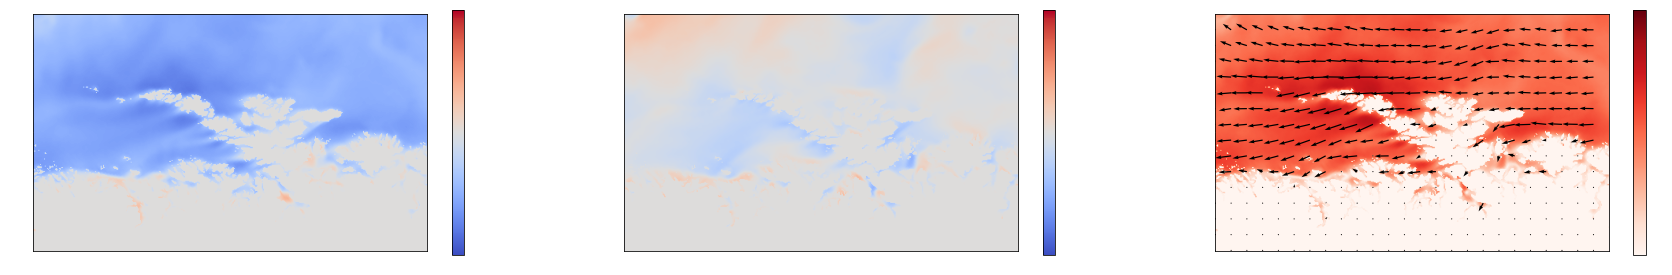

In [7]:
fig, axs = plt.subplots(1,3,figsize=(30,30))

wind_u = data_args["wind"].wind_u[t]
wind_v = data_args["wind"].wind_v[t]

im = axs[0].imshow(wind_u, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[0], shrink=0.15)

im = axs[1].imshow(wind_v, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[1], shrink=0.15)

wind_speed = np.sqrt( wind_u**2 + wind_v**2)
im = axs[2].imshow(wind_speed, vmin=0, vmax=10, cmap="Reds")
plt.colorbar(im, ax=axs[2], shrink=0.15)

freq = 20
x = np.arange(0, wind_speed.shape[1], freq)
y = np.arange(0, wind_speed.shape[0], freq)
qu = wind_u[::freq, ::freq]
qv = wind_v[::freq, ::freq]
quiv = axs[2].quiver(x,y,qu,qv, scale=150)

Wind field coarsend (factor 5)

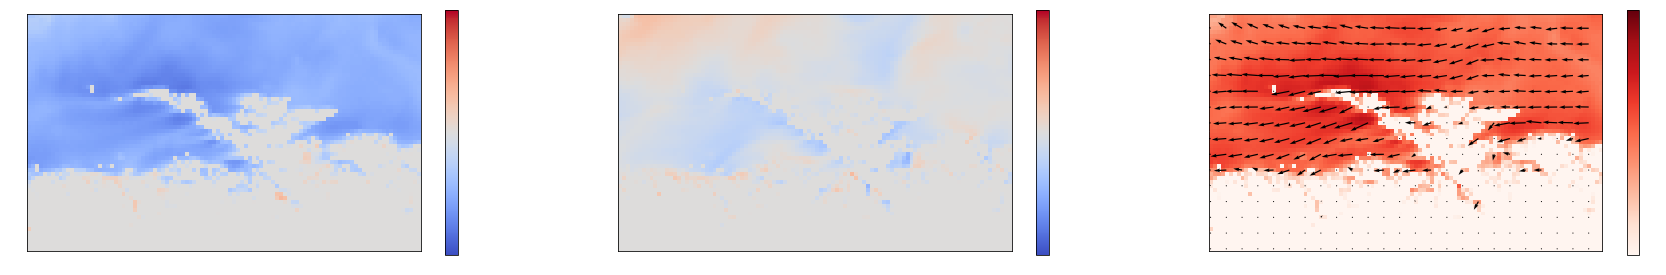

In [8]:
fig, axs = plt.subplots(1,3,figsize=(30,30))

wind_u = data_args["wind"].wind_u[t][::5,::5]
wind_v = data_args["wind"].wind_v[t][::5,::5]

im = axs[0].imshow(wind_u, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[0], shrink=0.15)

im = axs[1].imshow(wind_v, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[1], shrink=0.15)

wind_speed = np.sqrt( wind_u**2 + wind_v**2)
im = axs[2].imshow(wind_speed, vmin=0, vmax=10, cmap="Reds")
plt.colorbar(im, ax=axs[2], shrink=0.15)

freq = 4
x = np.arange(0, wind_speed.shape[1], freq)
y = np.arange(0, wind_speed.shape[0], freq)
qu = wind_u[::freq, ::freq]
qv = wind_v[::freq, ::freq]
quiv = axs[2].quiver(x,y,qu,qv, scale=150)

Sampler class for new wind

In [9]:
class SOARsampler:
    
    def __init__(self, nx, ny, dx, dy, L, q0, cutoff):
        self.nx, self.ny = nx, ny
        self.cutoff = cutoff
        self.dist_ref = np.zeros((2*cutoff+1, 2*cutoff+1))
        for a_y in range(2*cutoff+1):
            for a_x in range(2*cutoff+1):
                self.dist_ref[a_y, a_x] = SOARsampler.Q(a_x, a_y, cutoff, cutoff, dx, dy, q0, L)

    @staticmethod
    def Q(a_x, a_y, b_x, b_y, dx, dy, q0, L):
        dist = np.sqrt( dx*dx*(a_x - b_x)**2  +  dy*dy*(a_y - b_y)**2)
        return q0*(1.0 + dist/L)*np.exp(-dist/L)

    def pert(self, xi):
        Qxi = np.zeros_like(xi)
        for b_y in range(-self.cutoff, self.cutoff+1):
            for b_x in range(-self.cutoff, self.cutoff+1):
                if b_y >= 0 and b_x >= 0:
                    Qxi[b_y:, b_x:] += self.dist_ref[self.cutoff+b_y, self.cutoff+b_x] * np.roll(np.roll(xi,b_y, axis=0),b_x,axis=1)[b_y:, b_x:] 
                if b_y < 0 and b_x >= 0:
                    Qxi[:b_y, b_x:] += self.dist_ref[self.cutoff+b_y, self.cutoff+b_x] * np.roll(np.roll(xi,b_y, axis=0),b_x,axis=1)[:b_y, b_x:]
                if b_y >= 0 and b_x < 0:
                    Qxi[b_y:, :b_x] += self.dist_ref[self.cutoff+b_y, self.cutoff+b_x] * np.roll(np.roll(xi,b_y, axis=0),b_x,axis=1)[b_y:, :b_x]
                if b_y < 0 and b_x < 0:
                    Qxi[:b_y, :b_x] += self.dist_ref[self.cutoff+b_y, self.cutoff+b_x] * np.roll(np.roll(xi,b_y, axis=0),b_x,axis=1)[:b_y, :b_x]
            
        return Qxi

    def sample(self):
        xi = np.random.normal(size=(self.ny, self.nx))
        return self.pert(xi)



In [10]:
soar_sampler = SOARsampler(wind_u.shape[1], wind_u.shape[0], 4000, 4000, 16000, 0.005, 12)

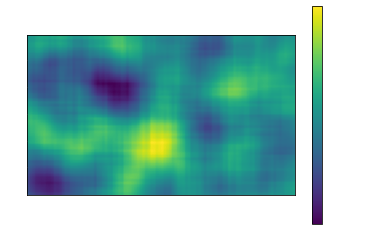

In [11]:
plt.imshow(soar_sampler.sample())
plt.colorbar()

Function for perturbing (and subsampling) input wind

In [12]:
from gpuocean.utils import WindStress

def SOARpertWind(data_args, subsampling_rate=5):
    wind = data_args["wind"]

    wind_u = wind.wind_u[:,::subsampling_rate,::subsampling_rate]
    wind_v = wind.wind_v[:,::subsampling_rate,::subsampling_rate]

    dx = data_args["dx"]*subsampling_rate
    dy = data_args["dy"]*subsampling_rate
    ny, nx = wind_u[0].shape

    soar_sampler = SOARsampler(nx, ny, dx, dy, 1.25*(dx+dy), 0.01, 10)

    wind_u_pert = np.zeros((24, ny, nx))
    wind_v_pert = np.zeros((24, ny, nx))
    for t in range(24):
        wind_u_pert[t] = soar_sampler.sample()
        wind_v_pert[t] = soar_sampler.sample()

    # wind_u_pert = np.cumsum(np.linspace(1,0.5,24)[:,np.newaxis,np.newaxis] * wind_u_pert, axis=0)
    # wind_v_pert = np.cumsum(np.linspace(1,0.5,24)[:,np.newaxis,np.newaxis] * wind_v_pert, axis=0)
    
    wind_u = (1+wind_u_pert)*wind_u
    wind_v = (1+wind_v_pert)*wind_v

    data_args["wind"] = WindStress.WindStress(t=wind.t, wind_u=wind_u.astype(np.float32), wind_v=wind_v.astype(np.float32))

    return data_args

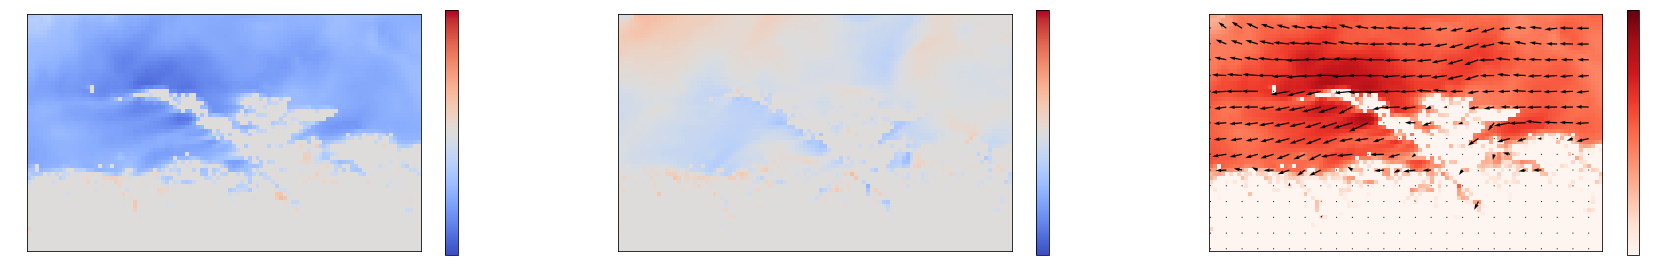

In [13]:
pert_data_args = SOARpertWind(data_args)


fig, axs = plt.subplots(1,3,figsize=(30,30))

wind_u = pert_data_args["wind"].wind_u[t]
wind_v = pert_data_args["wind"].wind_v[t]

im = axs[0].imshow(wind_u, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[0], shrink=0.15)

im = axs[1].imshow(wind_v, vmin=-10, vmax=10, cmap="coolwarm")
plt.colorbar(im, ax=axs[1], shrink=0.15)

wind_speed = np.sqrt( wind_u**2 + wind_v**2)
im = axs[2].imshow(wind_speed, vmin=0, vmax=10, cmap="Reds")
plt.colorbar(im, ax=axs[2], shrink=0.15)

freq = 4
x = np.arange(0, wind_speed.shape[1], freq)
y = np.arange(0, wind_speed.shape[0], freq)
qu = wind_u[::freq, ::freq]
qv = wind_v[::freq, ::freq]
quiv = axs[2].quiver(x,y,qu,qv, scale=150)

Variances

In [14]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
     }

In [15]:
N = 5

In [17]:
etas1 = np.zeros((N,data_args["ny"],data_args["nx"]))
hus1  = np.zeros((N,data_args["ny"],data_args["nx"]))
hvs1  = np.zeros((N,data_args["ny"],data_args["nx"]))

etas12 = np.zeros((N,data_args["ny"],data_args["nx"]))
hus12  = np.zeros((N,data_args["ny"],data_args["nx"]))
hvs12  = np.zeros((N,data_args["ny"],data_args["nx"]))

etas24 = np.zeros((N,data_args["ny"],data_args["nx"]))
hus24  = np.zeros((N,data_args["ny"],data_args["nx"]))
hvs24  = np.zeros((N,data_args["ny"],data_args["nx"]))

In [18]:
for e in range(N):
    pert_data_args = SOARpertWind(data_args)
    sim = CDKLM16.CDKLM16(**sim_args, **pert_data_args)
    
    sim.step(3600)
    etas1[e], hus1[e], hvs1[e] = sim.download(interior_domain_only=True)
    
    sim.step(11*3600)
    etas12[e], hus12[e], hvs12[e] = sim.download(interior_domain_only=True)
    
    sim.step(12*3600)
    etas24[e], hus24[e], hvs24[e] = sim.download(interior_domain_only=True)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [27]:
import copy

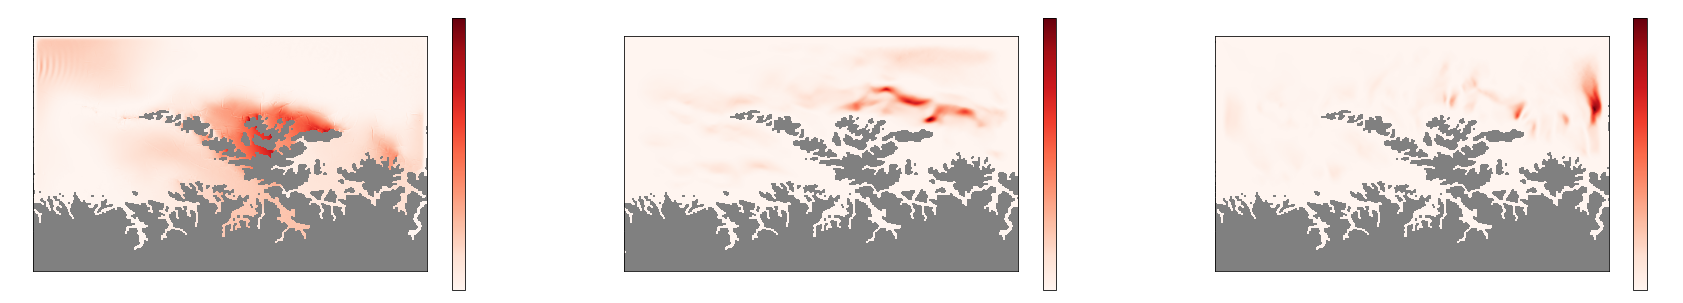

In [28]:
fig, axs = plt.subplots(1,3, figsize=(30,10))

cmap = copy.copy(plt.cm.Reds)
cmap.set_bad("grey")

var_eta = np.var(etas24, axis=0)
im = axs[0].imshow(np.ma.array(var_eta, mask=(var_eta==0)), cmap=cmap)
plt.colorbar(im, ax=axs[0], shrink=0.5)

var_hu = np.var(hus24, axis=0)
im = axs[1].imshow(np.ma.array(var_hu, mask=(var_hu==0)), cmap=cmap)
plt.colorbar(im, ax=axs[1], shrink=0.5)

var_hv = np.var(hvs24, axis=0)
im = axs[2].imshow(np.ma.array(var_hv, mask=(var_hv==0)), cmap=cmap)
plt.colorbar(im, ax=axs[2], shrink=0.5)